In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
yrdata = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdate = dt.datetime.strptime(yrdata[0], '%Y-%m-%d')
# Calculate the date 1 year ago from the last data point in the database
query = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
# Perform a query to retrieve the data and precipitation scores
sb = [Measurement.date,Measurement.prcp]
query_result = session.query(*sb).filter(Measurement.date >= query).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(query_result, columns=['Date','Precipitation'])
# Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")

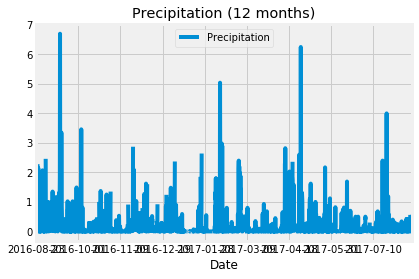

In [20]:
precipitation.plot(title = "Precipitation (12 months)")
plt.legend(loc ="upper center" )
plt.show()

![precipitation](Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [22]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sb = [Measurement.station,func.count(Measurement.id)]
stations = session.query(*sb).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sb = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
st_data = session.query(*sb).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
st_data

(54.0, 85.0, 71.66378066378067)

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()

sb = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sb).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

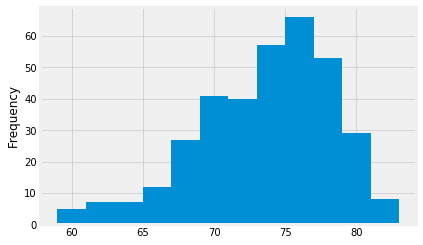

In [46]:
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.show()

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [71]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps("2017-02-01", "2017-02-10")
my_trip

[(59.0, 68.27272727272727, 80.0)]

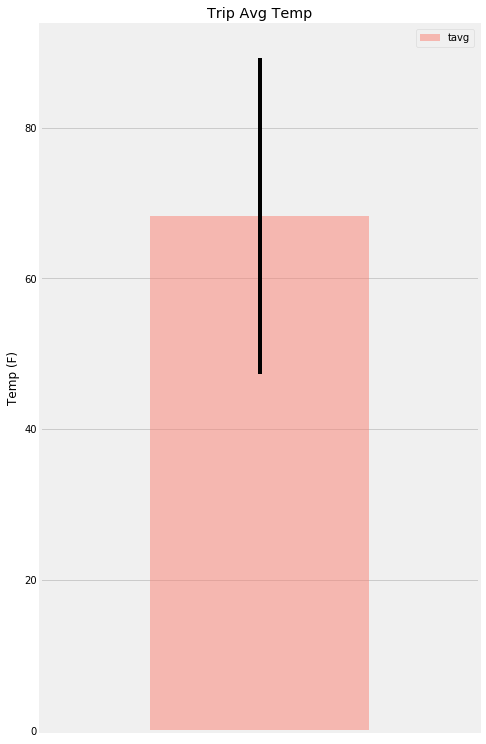

In [72]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip = pd.DataFrame(my_trip, columns=["tmin", "tavg", "tmax"])

my_trip.plot.bar(y="tavg", yerr=(my_trip["tmax"] - my_trip["tmin"]), title = "Trip Avg Temp", color = "salmon", alpha = 0.5, figsize = (7,13))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.show()

In [74]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sb = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]

rainfall =  session.query(*sb).\
                    group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= '2017-02-01').filter(Measurement.date <= '2017-02-10').\
                    order_by(func.sum(Measurement.tobs).desc()).all()
rainfall

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  705.0,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 675.0, 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 674.0, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  661.0,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  649.0,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  603.0,
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948', 'PEARL CITY, HI US', 539.0, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


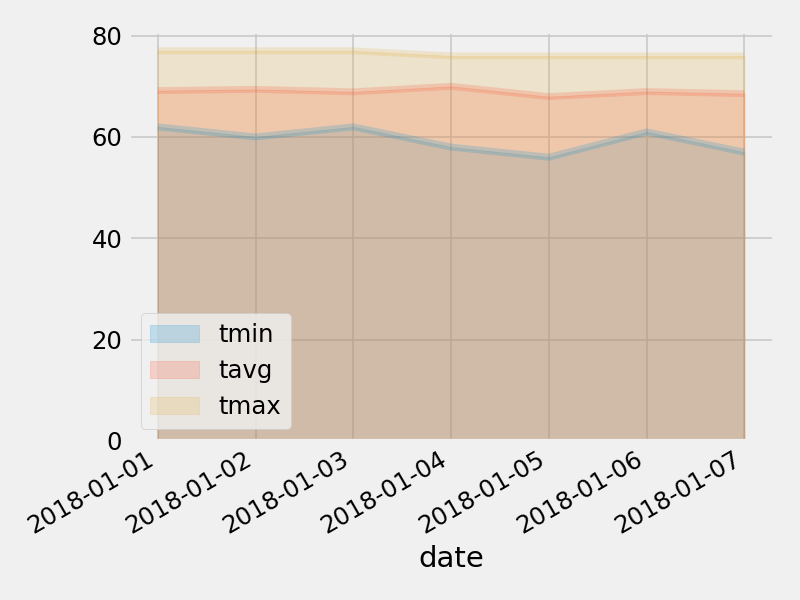

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
